# Plot the data

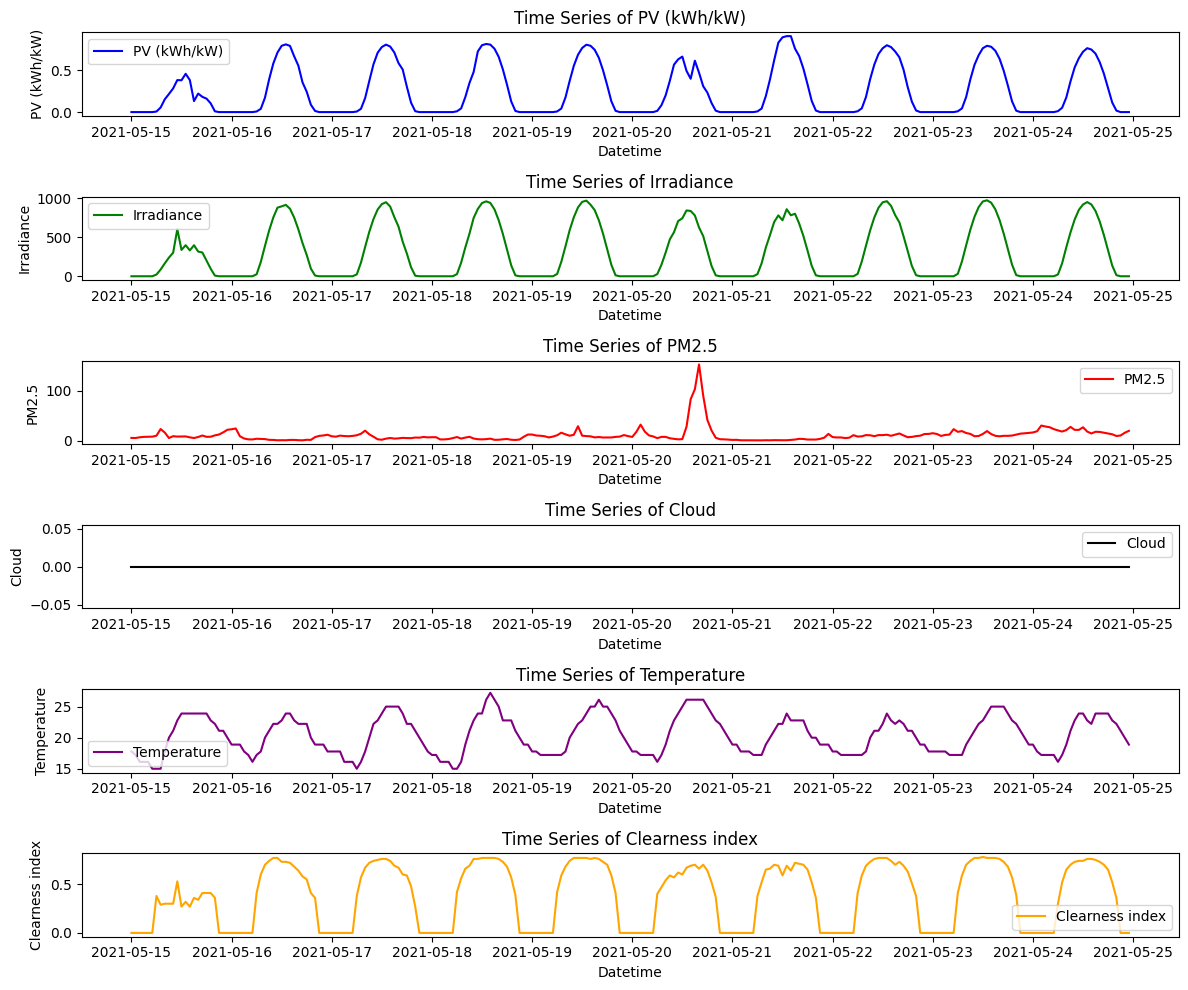

In [146]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import numpy as np

# Change the PV file here
file_name = 'QWERTY.csv'  # Replace with your file name
pv = 'PV (kWh/kW)'
irr = 'Irradiance'
pm25 = 'PM2.5'
cloud = 'Cloud'
temp = 'Temperature'
KT = 'Clearness index'
# Define your start and end dates for the regression analysis
start_date = '2021-05-17'
end_date = '2021-05-24'    # Until end_date - 1

# Load the dataset and drop rows with missing values
df = pd.read_csv(file_name).dropna(axis=0)

# Convert 'Datetime' column to datetime type and set it as index
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# Plotting all time series in one figure
plt.figure(figsize=(12, 10))

# Helper function to create a subplot for a variable
def plot_time_series(index, series, label, color):
    plt.subplot(6, 1, index)
    plt.plot(series, label=label, color=color)  # Plot the series directly
    plt.xlabel("Datetime")
    plt.ylabel(label)
    plt.title(f"Time Series of {label}")
    plt.legend()

# Plot each time series
plot_time_series(1, df[pv], pv, "blue")
plot_time_series(2, df[irr], irr, "green")
plot_time_series(3, df[pm25], pm25, "red")
plot_time_series(4, df[cloud], cloud, "black")
plot_time_series(5, df[temp], temp, "purple")
plot_time_series(6, df[KT], KT, "orange")  # Plot KT series

plt.tight_layout()
plt.show()



# Linear Regression - Cross Validation

In [147]:
# Filter the dataframe for the specified date range
df = df[(df.index >= start_date) & (df.index <= end_date)]

# Drop rows where the 'PV' column has zero values
df = df[df[pv] != 0]

# Separate the target variable and features, excluding specified columns
X = df.drop(columns=[pv, cloud, irr])
y = df[pv]

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize K-Fold cross-validation, n_split = 7 beacause the data set has 7 days in totals
kfold = KFold(n_splits=7, shuffle=True, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Perform cross-validation and calculate R-squared scores
cv_scores = cross_val_score(model, X_scaled, y, cv=kfold, scoring='r2')
print(f'Cross-validation R-squared scores: {cv_scores}')
print(f'Average R-squared: {cv_scores.mean()}')

# Train the model on the entire dataset
model.fit(X_scaled, y)

# Extracting and displaying the model's coefficients and intercept
weights = pd.DataFrame({"Feature": X.columns, "Weight": model.coef_})
print("Intercept:", model.intercept_)
print(weights)

Cross-validation R-squared scores: [0.7801811  0.60468062 0.53588718 0.52480409 0.67964378 0.77958195
 0.82744185]
Average R-squared: 0.6760315104877519
Intercept: 0.42874095238095233
           Feature    Weight
0            PM2.5 -0.048929
1      Temperature  0.114860
2  Clearness index  0.175342


# PV Reduction

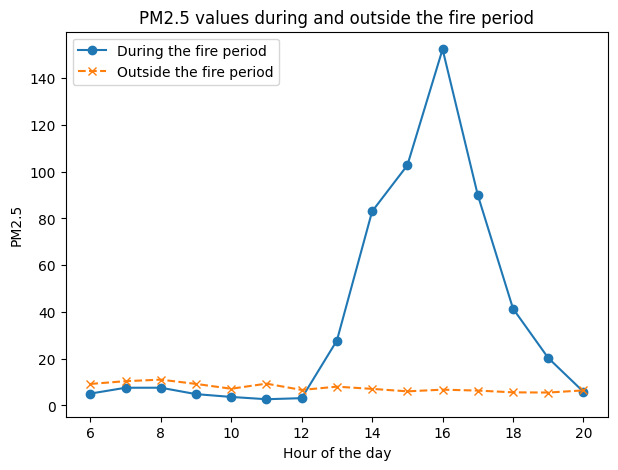

In [155]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Assuming 'X' is a DataFrame that includes 'PM2.5' data and has a datetime index

# Train the model on the non-scaled dataset
model_non_scaled = LinearRegression()
model_non_scaled.fit(X, y)  # Ensure 'y' is defined as your target variable

# Exclude May 20, 2021, from the dataset for the calculation of 'PM2.5' means
df_without_may_20 = X.loc[X.index.normalize() != datetime(2021, 5, 20)]

# Group by the hour and calculate the mean 'PM2.5' values
pm25_hourly_mean = df_without_may_20['PM2.5'].groupby(df_without_may_20.index.hour).mean()

# Plot PM2.5 for May 20, 2021, and the calculated hourly means
plt.figure(figsize=(7, 5))
hours = df.loc['2021-05-20'].index.hour
plt.plot(hours, X.loc['2021-05-20', 'PM2.5'], label='During the fire period', marker='o')
plt.plot(pm25_hourly_mean.index, pm25_hourly_mean.values, label='Outside the fire period', linestyle='--', marker = 'x')

plt.title('PM2.5 values during and outside the fire period')
plt.xlabel('Hour of the day')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

# Prepare the data from May 20, 2021, for prediction
may_20_data = X.loc['2021-05-20'].copy()

# Replace 'PM2.5' in May 20 data with the hourly means from non-fire days
for hour in may_20_data.index.hour:
    may_20_data.loc[may_20_data.index.hour == hour, 'PM2.5'] = pm25_hourly_mean.get(hour, np.nan)

# Make predictions for May 20, 2021, using the non-scaled model
predicted_PV_may_20 = model_non_scaled.predict(may_20_data)

# Replace any negative predicted values with 0
predicted_PV_may_20 = np.maximum(predicted_PV_may_20, 0)

# Convert the predictions to a Pandas Series with the correct time index
predicted_PV_may_20_series = pd.Series(predicted_PV_may_20, index=may_20_data.index)

# Extract actual 'y' values for May 20, 2021
actual_PV_may_20 = df.loc['2021-05-20', pv]  # Ensure 'pv' is defined as the target column in 'df'


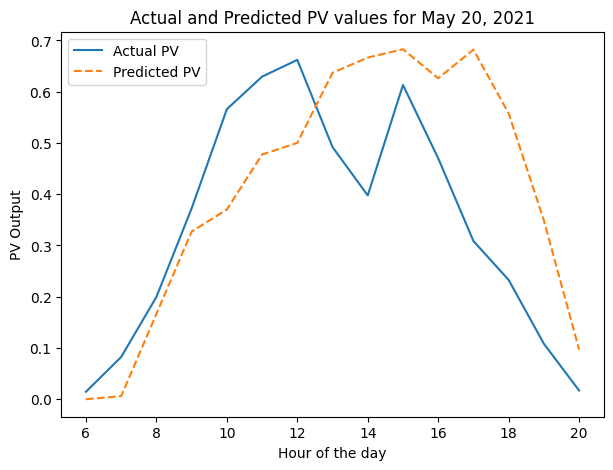

In [156]:
# Plotting actual values
plt.figure(figsize=(7, 5))
plt.plot(hours,actual_PV_may_20, label='Actual PV')

# Assuming predicted_y_may_20 is a NumPy array with the predicted values for May 20, 2021
plt.plot(hours,predicted_PV_may_20, label='Predicted PV', linestyle='--')

plt.title('Actual and Predicted PV values for May 20, 2021')
plt.xlabel('Hour of the day')
plt.ylabel('PV Output')
plt.legend()
plt.show()

In [157]:
#Calculate the reduction of PV production on May 20, 2021
PV_reduction = (predicted_PV_may_20.sum() - actual_PV_may_20.sum())*100/ predicted_PV_may_20.sum()
print("The reduction of PV production due to the fire is {:.2f}%".format(PV_reduction))

The reduction of PV production due to the fire is 15.94%


In [158]:
predicted_PV_may_20

array([0.        , 0.00593676, 0.16633006, 0.32697513, 0.37004874,
       0.47741564, 0.50006883, 0.63681553, 0.66654572, 0.68279066,
       0.62608703, 0.68201432, 0.55751827, 0.34891905, 0.09668032])